In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

In [40]:
def totalVariationDistance(P: np.ndarray, Q: np.ndarray) -> float:
    delta = abs(P - Q)
    totalVariation = 0.5*delta.sum()
    return totalVariation

In [41]:
def powerIterationGenerator(pi_0: np.ndarray, P: np.ndarray, N: int = 10**3):
    pi_current = pi_0
    yield pi_current
    for i in tqdm(range(1, N+1)):
        pi_last = pi_current
        pi_current = np.matmul(pi_last, P)
        yield pi_current

In [42]:
def totalVariationEvolution(pi_0: np.ndarray, P: np.ndarray, N: int = 10**3, stationaryDist = np.ndarray):
    totalVariation = []
    for i, pi_current in enumerate(powerIterationGenerator(pi_0, P, N)):
        totalVariation.append([i, totalVariationDistance(pi_current, stationaryDist)])
    totalVariation = pd.DataFrame(data = totalVariation, columns = ["step", "totalVariation"])
    return totalVariation, pi_current

In [43]:
def plotTotalVariation(pi_0: np.ndarray, P: np.ndarray, N: int = 10**3, stationaryDist: np.ndarray = None):
    totalVariation, _ = totalVariationEvolution(pi_0, P, N, stationaryDist)
    fig = sns.lineplot(data = totalVariation, x = 'step', y = 'totalVariation')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([0,1])
    return fig

In [44]:
totalVariation_ring, pi_ring = totalVariationEvolution(pi_0_ring, P_ring, 10**3, stationaryDist_ring)
totalVariation_tree, pi_tree = totalVariationEvolution(pi_0_tree, P_tree, 10**3, stationaryDist_tree)
totalVariation_grid, pi_grid = totalVariationEvolution(pi_0_grid, P_grid, 10**3, stationaryDist_grid)

100%|██████████| 1000/1000 [00:00<00:00, 6465.24it/s]


## **Ring**

In [45]:
n_ring = 100
stationaryDist_ring = [1/n_ring for i in range(n_ring)]

In [46]:
P_ring = np.zeros((n_ring,n_ring))
for i in range(n_ring):
    P_ring[i,i] = 1/2
    for j in range(n_ring):
        if (j == (i+1)%n_ring) or (j == (i-1)%n_ring):
            P_ring[i,j] = 1/4

# pi_0 = np.array([1/n for i in range(n)])
pi_0_ring = np.zeros(n_ring)
pi_0_ring[0] = 1

100%|██████████| 1000/1000 [00:00<00:00, 3125.07it/s]
/tmp/ipykernel_9036/1243025884.py:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0,1])


Text(0.5, 1.0, 'Total Variation Distance - Ring')

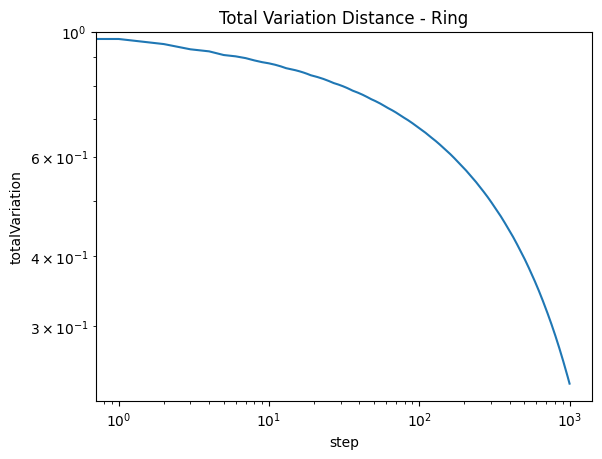

In [47]:
plotTotalVariation(pi_0_ring, P_ring, stationaryDist = stationaryDist_ring)
plt.title("Total Variation Distance - Ring")

## **Full Binary Tree**

In [48]:
n_tree = 127
piRoot = 2/252
piInner = 3/252
piLeaf = 1/252
stationaryDist_tree = [piRoot]
stationaryDist_tree += [piInner for i in range(62)]
stationaryDist_tree += [piLeaf for i in range(64)]

In [49]:
P_tree = np.zeros((n_tree, n_tree))
for i in range(1, n_tree+1):
    for j in range(1, n_tree+1):
        if i == j:
            P_tree[i-1,j-1] = 1/2
        elif i == 1 and j in [2,3]:
            P_tree[i-1,j-1] = 1/4
        elif i > 63 and j == int(i/2):
            P_tree[i-1,j-1] = 1/2
        elif i >= 2 and i <= 63 and j in [int(i/2), 2*i, 2*i+1]:
            P_tree[i-1,j-1] = 1/6

# pi_0 = np.array([1/n for i in range(n)])
pi_0_tree = np.zeros(n_tree)
pi_0_tree[0] = 1

100%|██████████| 1000/1000 [00:00<00:00, 2262.75it/s]
/tmp/ipykernel_9036/1243025884.py:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0,1])


Text(0.5, 1.0, 'Total Variation Distance - Full Binary Tree')

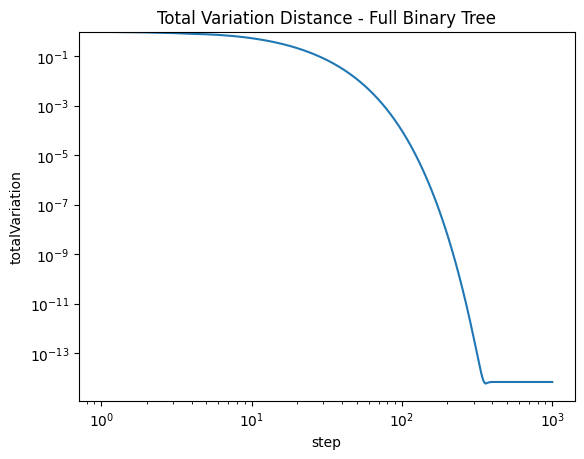

In [50]:
plotTotalVariation(pi_0_tree, P_tree, stationaryDist = stationaryDist_tree)
plt.title("Total Variation Distance - Full Binary Tree")

## **2D Grid**

In [51]:
n_grid = 100
rows = 10
columns = int(n_grid/rows) if (n_grid%rows == 0) else None
stationaryDist_grid = [[2/360, *[3/360 for i in range(columns - 2)], 2/360]]
stationaryDist_grid += [[3/360, *[4/360 for i in range(columns - 2)], 3/360] for j in range(rows - 2)]
stationaryDist_grid += [[2/360, *[3/360 for i in range(columns - 2)], 2/360]]
stationaryDist_grid = np.array(stationaryDist_grid).flatten()

In [52]:
def gridRowAndColumn(rows, columns, n_grid):
    row = int((n_grid-1)/columns) + 1
    column = ((n_grid-1) % columns) + 1
    return row, column

P_grid = np.zeros((n_grid, n_grid))
for i in range(1, n_grid+1):
    P_grid[i-1, i-1] = 1/2
    row, column = gridRowAndColumn(rows, columns, i)
    neighbors = []
    for k in [i-1, i+1, i-columns, i+columns]:
        neighborRow, neighborColumn = gridRowAndColumn(rows, columns, k)
        if 1 <= k <= n_grid and (neighborRow == row or neighborColumn == column):
            neighbors.append(k)
    probability = None
    # Corner
    if row in [1, rows] and column in [1, columns]:
        probability = 1/4
        
    # Border
    elif np.logical_xor(row in [1, rows], column in [1, columns]):
        probability = 1/6

    # Inner
    elif row not in [1, rows] and column not in [1, columns]:
        probability = 1/8

    for j in neighbors:
        P_grid[i-1,j-1] = probability
        
# pi_0 = np.array([1/n for i in range(n)])
pi_0_grid = np.zeros(n_grid)
pi_0_grid[0] = 1

100%|██████████| 1000/1000 [00:00<00:00, 14145.86it/s]
/tmp/ipykernel_9036/1243025884.py:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0,1])


Text(0.5, 1.0, 'Total Variation Distance - Grid 10x10')

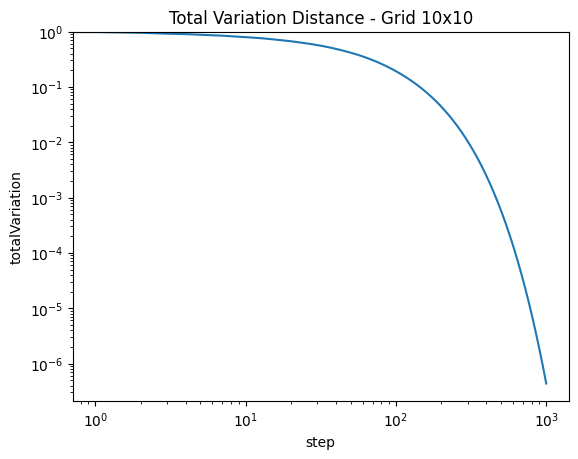

In [53]:
plotTotalVariation(pi_0_grid, P_grid, stationaryDist = stationaryDist_grid)
plt.title("Total Variation Distance - Grid 10x10")

In [54]:
totalVariationDF = pd.concat([totalVariation_ring, totalVariation_tree, totalVariation_grid])
totalVariationDF["graph"] = np.array([[graph for i in range(totalVariation_ring.shape[0])] for graph in ["Ring", "Full Binary Tree", "2D Grid"]]).flatten()
totalVariationDF = totalVariationDF.reset_index(drop = True)
totalVariationDF

,step,totalVariation,graph
0,0,9.900000e-01,Ring
1,1,9.700000e-01,Ring
2,2,9.500000e-01,Ring
3,3,9.300000e-01,Ring
4,4,9.221875e-01,Ring
...,...,...,...
2998,996,4.611813e-07,2D Grid
2999,997,4.545869e-07,2D Grid
3000,998,4.480867e-07,2D Grid
3001,999,4.416795e-07,2D Grid


Text(0.5, 1.0, 'Total Variation for Different Graph Structures')

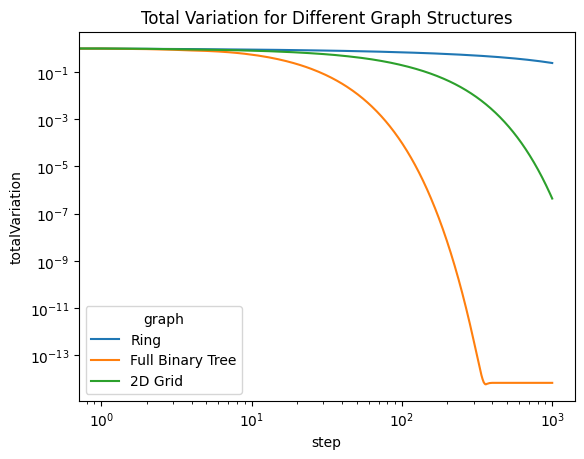

In [57]:
sns.lineplot(data = totalVariationDF, x = "step", y = "totalVariation", hue = "graph")
plt.xscale("log")
plt.yscale("log")
plt.title("Total Variation for Different Graph Structures")